# Inference

This notebook enables to predict the closest images of a sketch. 

In [43]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['axes.titlesize'] = 15

In [44]:
from src.data.loader_factory import load_data
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint
from src.models.test import get_test_data
from src.models.metrics import get_similarity

In [50]:
class Args:
    dataset = "sketchy_extend"
    data_path = "../io/data/raw"
    emb_size = 256
    grl_lambda = 0.5
    nopretrain = False
    epochs = 1000
    batch_size = 10
    seed = 42
    load = None
    early_stop = 20
    ngpu = 1
    prefetch = 2
    log = "../io/models/"
    log_interval = 20
    attn = True
    plot = False
    cuda = False

args = Args()

## Load the model

In [46]:
BEST_CHECKPOINT = '../io/models/1_run-batch_size_10/checkpoint.pth'

In [47]:
def get_model(args, best_checkpoint):
    im_net = EncoderCNN(out_size=args.emb_size, attention=True)
    sk_net = EncoderCNN(out_size=args.emb_size, attention=True)
    
    #checkpoint = load_checkpoint(best_checkpoint)
    checkpoint = torch.load(best_checkpoint, map_location='cpu')
    
    im_net.load_state_dict(checkpoint['im_state'])
    sk_net.load_state_dict(checkpoint['sk_state'])

    if args.cuda and args.ngpu > 1:
        print('\t* Data Parallel **NOT TESTED**')
        im_net = nn.DataParallel(im_net, device_ids=list(range(args.ngpu)))
        sk_net = nn.DataParallel(sk_net, device_ids=list(range(args.ngpu)))

    if args.cuda:
        print('\t* CUDA')
        im_net, sk_net = im_net.cuda(), sk_net.cuda()

    return im_net, sk_net

In [48]:
im_net, sk_net = get_model(args, BEST_CHECKPOINT)

## Get all images and compute their embeddings

In [49]:
transform = transforms.Compose([transforms.ToTensor()])
_, [_, _], [test_sk_data, test_im_data], dict_class = load_data(args, transform)

FileNotFoundError: [Errno 2] No such file or directory: '../io/data/raw/Sketchy/zeroshot_classes_sketchy.txt'

In [ ]:
print("Length Sketch: {}".format(len(test_sk_data)))
print("Length Image: {}".format(len(test_im_data)))
print("Classes: {}".format(test_sk_data.get_class_dict()))
print("Num Classes: {}".format(len(test_sk_data.get_class_dict())))

In [ ]:
test_im_loader = DataLoader(test_im_data, batch_size=3 * args.batch_size, num_workers=args.prefetch, pin_memory=True)
test_sk_loader = DataLoader(test_sk_data, batch_size=3 * args.batch_size, num_workers=args.prefetch, pin_memory=True)

In [ ]:
def get_test_data(data_loader, model, args):
    fnames = []
    for i, (image, target, fname) in enumerate(data_loader):
        # Process
        out_features, _ = model(image)

        # Filename of the images for qualitative
        fnames.append(fname)

        if i == 0:
            embeddings = out_features
            classes = target
        else:
            embeddings = np.concatenate((embeddings, out_features), axis=0)
            classes = np.concatenate((classes, target), axis=0)

In [ ]:
images_fnames, images_embeddings, images_classes = get_test_data(test_im_loader, im_net, args)
sketch_fnames, sketch_embeddings, sketch_classes = get_test_data(test_sk_loader, sk_net, args)

In [ ]:
print(len(images_fnames))
print(len(sketch_fnames))
print(images_embeddings.shape)
print(sketch_embeddings.shape)

## Find closest images

Similarity measure between a sketch and images

### Choose a sketch

In [21]:
SKETCH_INDEX = 0

In [ ]:
sketch_embeddings.shape

In [ ]:
sketch_embedding = sketch_embeddings[SKETCH_INDEX]

In [ ]:
sketch_embedding.shape

### Compute similarity

In [ ]:
similarity = get_similarity(sketch_embedding, images_embeddings)

In [ ]:
similarity.shape

In [ ]:
arg_sorted_sim = (-similarity).argsort()

In [ ]:
arg_sorted_sim.shape

## Plot results

In [52]:
NUM_CLOSEST = 4 # number of cloest images to plot

In [53]:
sketch_fnames = ['../io/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-1.png']
images_fnames = [
                    '../io/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-2.png',
                    '../io/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-3.png',
                    '../io/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-4.png',
                    '../io/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-5.png'
                ]
closest_images = [2, 1, 0, 3]

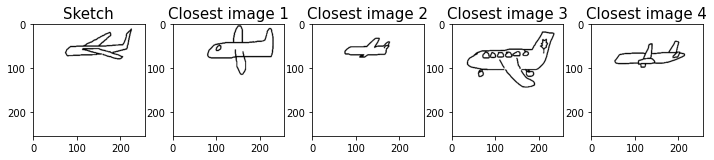

In [54]:
fig, axes = plt.subplots(1, NUM_CLOSEST + 1)

sk = mpimg.imread(sketch_fnames[SKETCH_INDEX])
axes[0].imshow(sk)
axes[0].set(title='Sketch')

for i in range(1, NUM_CLOSEST + 1):
    im = mpimg.imread(images_fnames[closest_images[i-1]])
    axes[i].imshow(im)
    axes[i].set(title='Closest image ' + str(i))
    
plt.subplots_adjust(wspace=0.25, hspace=-0.35)

In [51]:
class Inference():
    
    def __init__(model_path):
        
        self.im_net, self.sk_net = get_model(args, model_path)
        self.prepare_image_embeddings()
        
    def prepare_image_embeddings(self)
        '''Get all images and compute their embeddings'''
        transform = transforms.Compose([transforms.ToTensor()])
        
        #test_im_data, dict_class = load_inference_data(args, transform) TODO one with all class
        _, [_, _], [test_sk_data, test_im_data], dict_class = load_data(args, transform)
        
        test_im_loader = DataLoader(test_im_data, batch_size=3 * args.batch_size, num_workers=args.prefetch, pin_memory=True)
        self.images_fnames, self.images_embeddings, self.images_classes = get_test_data(test_im_loader, im_net, args)
        
    def process_sketch(self, sketch_path, plot=True):
        ''' For now just process a sketch but TODO decide how to proceed later'''
        
        self.sketch_path = sketch_path
        sketch = torch.tensor(mpimg.imread(sketch_path))
        embedding, _ = self.sk_net(sketch)
        self.get_closest_images(embedding)
        
        if plot:
            self.plot_closest()
        
    def get_closest_images(self, sketch_embedding):
        '''
        Based on a sketch embedding, retrieve the index of the closest images
        '''
        
        similarity = get_similarity(sketch_embedding, self.images_embeddings)
        arg_sorted_sim = (-similarity).argsort()
        self.closest_images_fnames = []  # path to closest images (same index as closest image embeddings)
        
    def plot_closest(self):
        fig, axes = plt.subplots(1, NUM_CLOSEST + 1)

        sk = mpimg.imread(self.sketch_path)
        axes[0].imshow(sk)
        axes[0].set(title='Sketch')

        for i in range(1, NUM_CLOSEST + 1):
            im = mpimg.imread(self.closest_images_fnames[i-1])
            axes[i].imshow(im)
            axes[i].set(title='Closest image ' + str(i))

        plt.subplots_adjust(wspace=0.25, hspace=-0.35)

In [ ]:
inference = Inference(BEST_CHECKPOINT)

In [ ]:
closest_images = inference.process_sketch(sketch_fnames[0], plot=True)